In this notebook, we will show how to load pre-trained models and draw things with sketch-rnn

In [0]:
# import the required libraries
!pip install numpy==1.16.1
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [0]:
!pip install -qU svgwrite

In [0]:
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [0]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


INFO:tensorflow:TensorFlow Version: 1.13.1


In [0]:
!pip install -q magenta

In [0]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [0]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, svg_filename="testing.svg", factor=1000):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  print(min_x, max_x, min_y, max_y)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [0]:
data_dir = '/content/drive/My Drive/**CHANGE FOR YOUR FILEPATH**'
model_dir = '/content/drive/My Drive/**CHANGE FOR YOUR FILEPATH**'
models_root_dir = '/content/drive/**CHANGE FOR YOUR FILEPATH**'

In [0]:
download_pretrained_models(models_root_dir=models_root_dir)

INFO:tensorflow:/content/drive/My Drive/gps_locations/sketch_rnn.zip already exists, using cached copy
INFO:tensorflow:Unzipping /content/drive/My Drive/gps_locations/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


In [0]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [0]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

INFO:tensorflow:Loaded 1185/100/100 from low_cov_normalized.npz
INFO:tensorflow:Dataset combined: 1385 (1185/100/100), avg len 100
INFO:tensorflow:model_params.max_seq_len 101.
total images <= max_seq_len is 1185
total images <= max_seq_len is 100
total images <= max_seq_len is 100
INFO:tensorflow:normalizing_scale_factor 0.9167.


In [0]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [0]:
!sketch_rnn_train --data_dir='/content/drive/My Drive/**CHANGE FOR YOUR FILEPATH**' --log_root='/content/drive/My Drive/**CHANGE FOR YOUR FILEPATH**' --hparams=data_set=['low_cov_normalized.npz'],num_steps=500,conditional=1,dec_rnn_size=512,save_every=50


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:sketch-rnn
INFO:tensorflow:Hyperparams:
INFO:tensorflow:grad_clip = 1.0
INFO:tensorflow:conditional = True
INFO:tensorflow:min_learning_rate = 1e-05
INFO:tensorflow:num_mixture = 20
INFO:tensorflow:is_training = True
INFO:tensorflow:input_dropout_prob = 0.9
INFO:tensorflow:kl_decay_rate = 0.99995
INFO:tensorflow:kl_tolerance = 0.2
INFO:tensorflow:random_scale_factor = 0.15
INFO:tensorflow:decay_rate = 0.9999
INFO:tensorflow:use_recurrent_dropout = True
INFO:tensorflow:num_steps = 500
INFO:tensorflow:use_output_dropout = False
INFO:tensorflow:max_seq_len = 250
INFO:tensorflow:z_size = 128
INFO:tensorflow:augment_stroke_prob = 0.1
INFO:tensorflow:learning_rate = 0.001
INFO:tensorflow:batch_size = 100
INFO:tensorflow:enc_model = lstm
INFO:te

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /content/drive/My Drive/ECE 188/gps_locations/logs_low_cov_normalized2/vector-450.
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/ECE 188/gps_locations/logs_low_cov_normalized2/vector-450


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [0]:
def encode(input_strokes):
    strokes = to_big_strokes(input_strokes).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    z = sess.run(eval_model.batch_z,
                 feed_dict={
                    eval_model.input_data: [strokes], 
                    eval_model.sequence_lengths: seq_len})[0]
    return z

In [0]:
def decode(temperature, z_input=None, draw_mode=True, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
#   if draw_mode==True:
#     draw_strokes(strokes, factor)
  return strokes

In [0]:
# np.load('/content/drive/My Drive/ECE 188/gps_locations/multistroke_rivers.npz')['arr_0'][0][0:100]

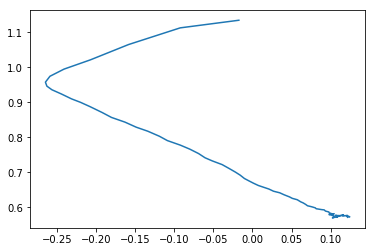

In [0]:
z_0 = np.random.randn(eval_model.hps.z_size)
# know = encode(np.load('/content/drive/My Drive/ECE 188/gps_locations/multistroke_rivers.npz')['arr_0'][0][0:100])
river_gen = decode(0.08)#[0:20]
river_coords = [zip(*river_gen)[0],zip(*river_gen)[1]]
import matplotlib.pyplot as plt
plt.plot(*river_coords)
plt.show()

In [0]:
# irrawaddy = np.load('/content/drive/My Drive/ECE 188/gps_locations/multistroke_rivers.npz')['arr_0'][0]
# draw_strokes(irrawaddy, '/content/drive/My Drive/ECE 188/gps_locations/irrawaddy.svg')